# Dataset exploration

## Load data and libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


df = pd.read_csv('..\\assignment-1\\data\\train.csv')

## Count missing values

In [5]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

property_id                    0
property_name                 24
property_summary             212
property_space              2309
property_desc                  3
property_neighborhood       2811
property_notes              4522
property_transit            2580
property_access             3135
property_interaction        3404
property_rules              3169
property_zipcode             134
property_lat                   0
property_lon                   0
property_type                  0
property_room_type             0
property_max_guests            0
property_bathrooms            12
property_bedrooms              9
property_beds                 11
property_bed_type              0
property_amenities            52
property_sqfeet             6333
property_scraped_at            0
property_last_updated          0
host_id                        0
host_since                     1
host_location                 33
host_about                  3107
host_response_time          1461
host_respo

## Correlogram

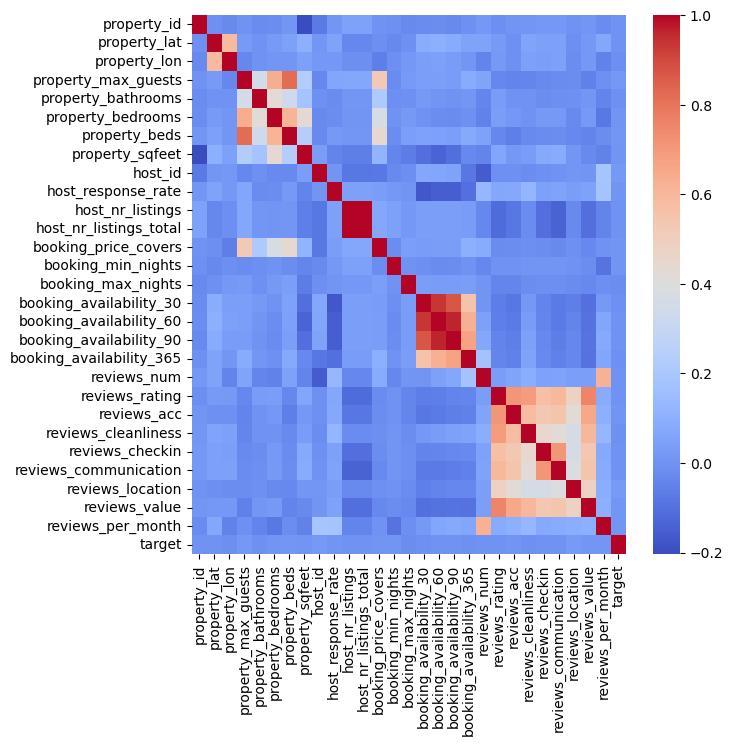

In [9]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

## Scatterplots

['property_id', 'property_lat', 'property_lon', 'property_max_guests', 'property_bathrooms', 'property_bedrooms', 'property_beds', 'property_sqfeet', 'host_id', 'host_response_rate', 'host_nr_listings', 'host_nr_listings_total', 'booking_price_covers', 'booking_min_nights', 'booking_max_nights', 'booking_availability_30', 'booking_availability_60', 'booking_availability_90', 'booking_availability_365', 'reviews_num', 'reviews_rating', 'reviews_acc', 'reviews_cleanliness', 'reviews_checkin', 'reviews_communication', 'reviews_location', 'reviews_value', 'reviews_per_month']


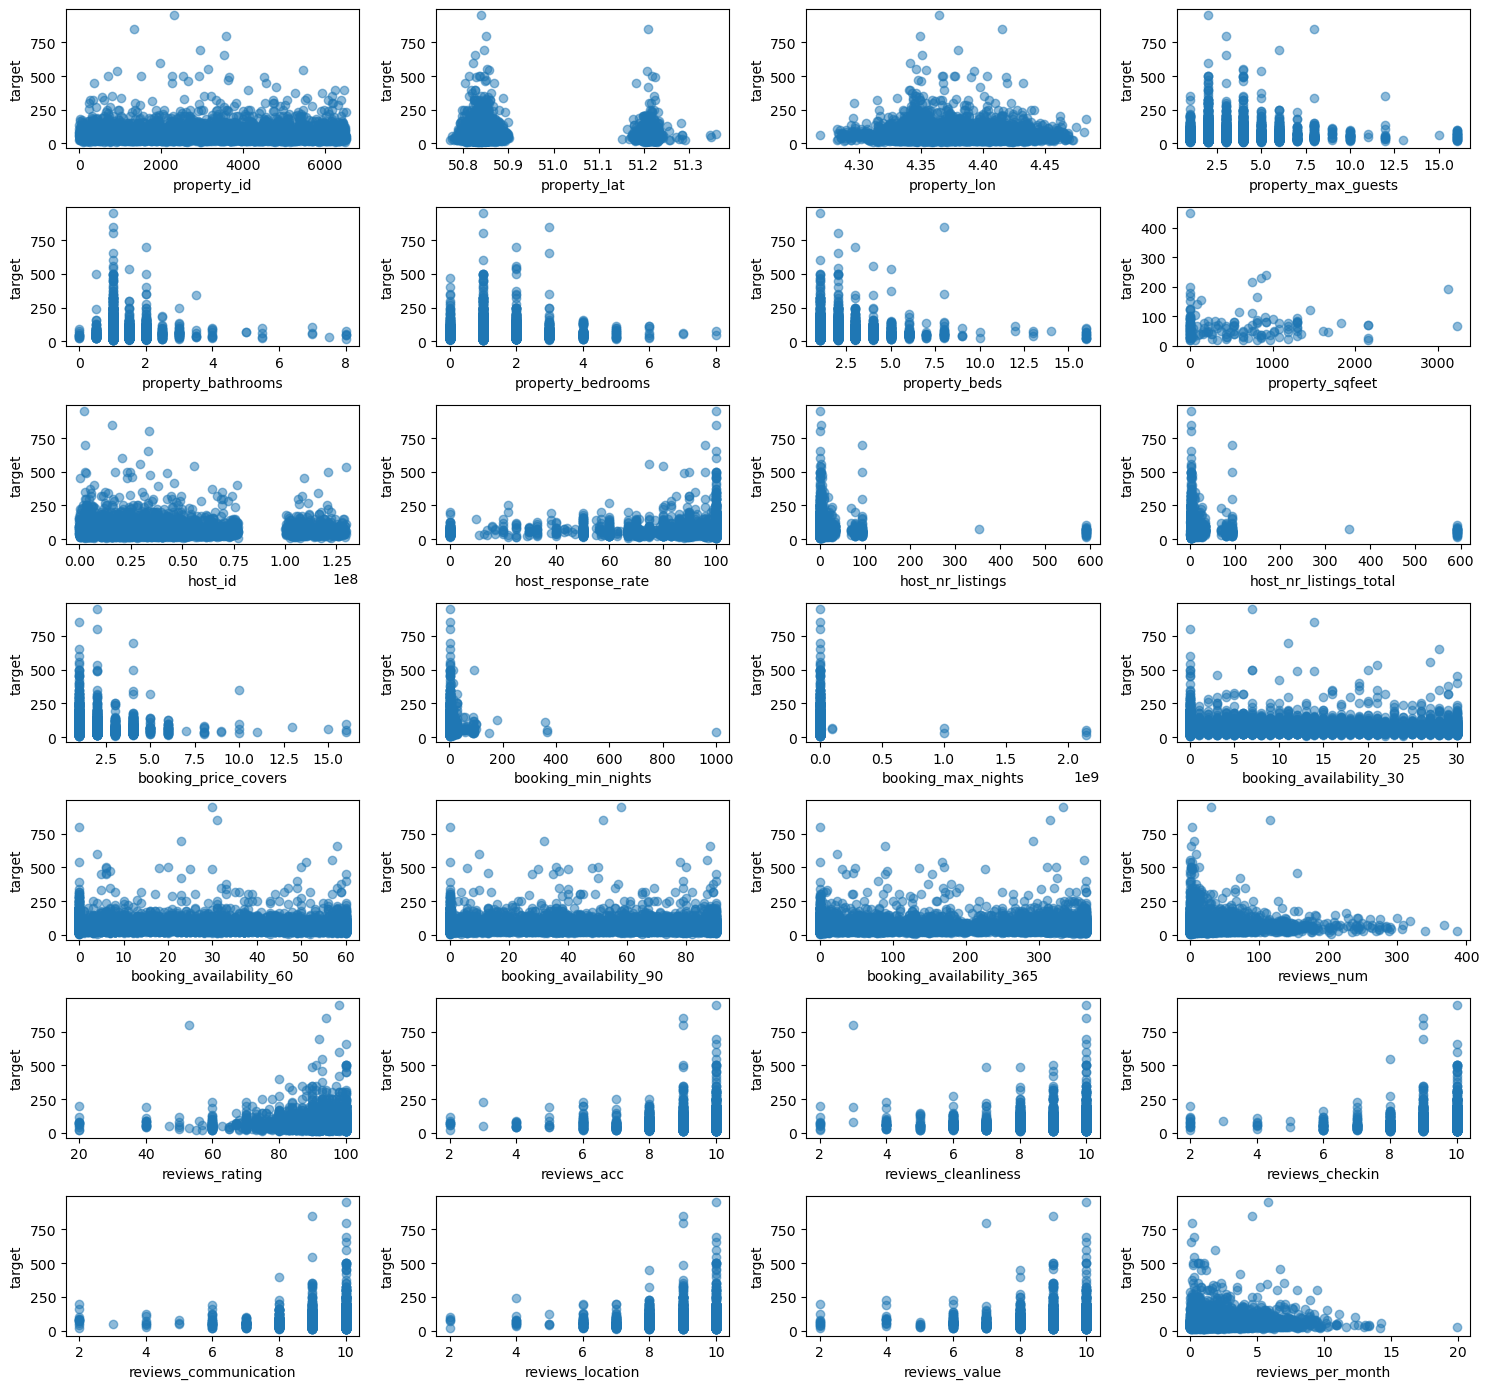

In [20]:
columns = [col for col in df.columns if col != 'target' and pd.api.types.is_numeric_dtype(df[col])]
n_plots_per_row = 4
n_rows = (len(columns) + n_plots_per_row - 1) // n_plots_per_row

fig, axes = plt.subplots(nrows=n_rows, ncols=n_plots_per_row, figsize=(15, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    ax.scatter(df[col], df['target'], alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('target')

plt.tight_layout()
plt.show()


<Axes: xlabel='property_room_type', ylabel='target'>

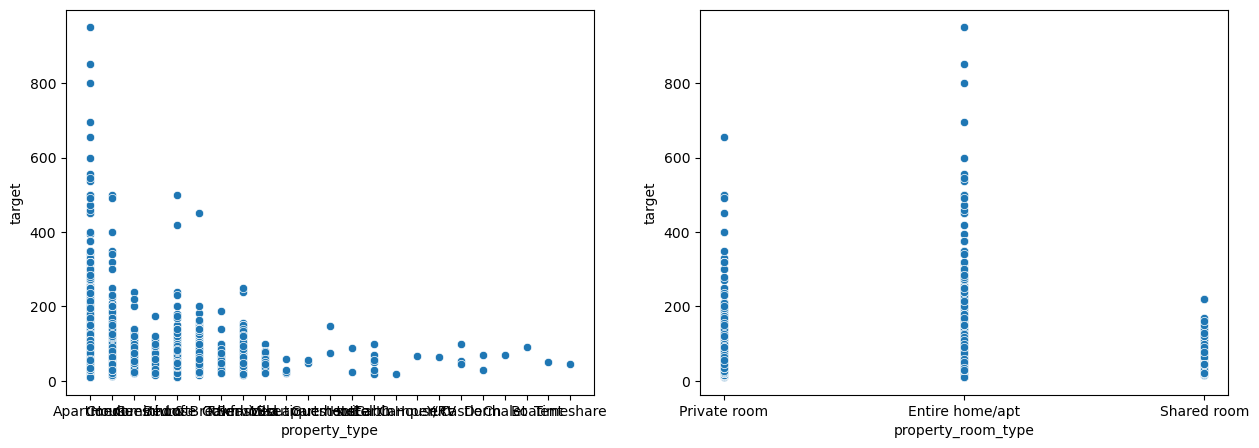

In [18]:
# scatterplot property_type and property_room_type vs target
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes = axes.flatten()

sns.scatterplot(x='property_type', y='target', data=df, ax=axes[0])
sns.scatterplot(x='property_room_type', y='target', data=df, ax=axes[1])


## Exploring location vs target

### Plotting on map (training set)

In [13]:
# Define map and colors
m = folium.Map(location=[df['property_lat'].mean(), df['property_lon'].mean()], zoom_start=10, control_scale=True)
cmap = cm.get_cmap('seismic')
df['target_log'] = np.log(df['target'])
colormap = {value: colors.rgb2hex(cmap((value - df['target_log'].min()) / (df['target_log'].max() - df['target_log'].min()))) for value in df['target_log'].unique()}

# Add points to the map
for index, row in df.iterrows():
    folium.CircleMarker(location=[row['property_lat'], row['property_lon']],
                        radius=3,
                        color='none',
                        fill_color=colormap[row['target_log']],
                        fill_opacity=1).add_to(m)
    
m


C:\Users\herre\AppData\Local\Temp\ipykernel_15500\3605964823.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic')


### Plotting on map (test set)

In [14]:
df2 = pd.read_csv('..\\assignment-1\\data\\test.csv')

m = folium.Map(location=[df2['property_lat'].mean(), df2['property_lon'].mean()], zoom_start=10, control_scale=True)
for index, row in df2.iterrows():
    folium.CircleMarker(location=[row['property_lat'], row['property_lon']],
                        radius=3,
                        color='none',
                        fill_color='black',
                        fill_opacity=1).add_to(m)
m

### Investigation of location-based KNN vs target

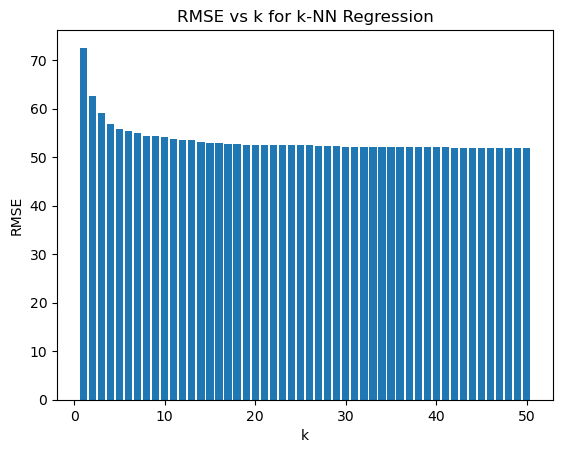

In [19]:
target_col = 'target'
lat_col = 'property_lat'
lon_col = 'property_lon'

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[[lat_col, lon_col]], df[target_col], test_size=0.3)

# Define the range of k values to test
k_range = range(1, 51)

# Define a function to calculate the RMSE for a given k value
def knn_rmse(k):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    return rmse

# Calculate the RMSE for each k value
rmse_values = [knn_rmse(k) for k in k_range]

# Plot the RMSE values for each k value
fig, ax = plt.subplots()
ax.bar(k_range, rmse_values)
ax.set_xlabel('k')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs k for k-NN Regression')
plt.show()
